In [1]:
# Download the resources
!wget --no-check-certificate \
https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
-O /content/rockpaperscissors.zip

--2020-06-20 08:37:34--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/content/rockpaperscissors.zip’

/content/rockpapers 100%[===================>] 307.92M  8.80MB/s    in 43s     

2020-06-20 08:38:18 (7.15 MB/s) - ‘/content/rockpaperscissors.zip’ saved [322873683/322873683]



In [2]:
# Extract the resources
import zipfile
resources = zipfile.ZipFile('/content/rockpaperscissors.zip', 'r')
resources.extractall('/content')
resources.close()

In [3]:
# Make the submission directory
import os
os.makedirs('/content/submission')
directory = '/content/submission'
classes = ['/paper', '/rock', '/scissors']

In [4]:
import shutil
import numpy as np

# Set the ratio of validation
val_ratio = 0.25

# Split the images to train and validation
for cls in classes:
  os.makedirs(directory + '/train' + cls)
  os.makedirs(directory + '/val' + cls)

  folder = '/content/rockpaperscissors' + cls
  images = os.listdir(folder)
  np.random.shuffle(images)

  train, val = np.split(np.array(images),
                        [int(len(images)*(1 - val_ratio))])
  
  train = [folder + '/' + name for name in train.tolist()]
  val = [folder + '/' + name for name in val.tolist()]

  print(str(cls).replace('/', ''))
  print('Total images: ', len(images))
  print('Training images: ', len(train))
  print('Validation images: ', len(val), '\n')

  for name in train:
    shutil.copy(name, directory + '/train' + cls)
  for name in val:
    shutil.copy(name, directory + '/val' + cls)

paper
Total images:  712
Training images:  534
Validation images:  178 

rock
Total images:  726
Training images:  544
Validation images:  182 

scissors
Total images:  750
Training images:  562
Validation images:  188 



In [5]:
from keras.preprocessing import image

# Set the image augmentation
image_aug = image.ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    #vertical_flip=True,
    rescale=1./255
)

# Set the train and validation directory
train_dir = '/content/submission/train'
val_dir = '/content/submission/val'

Using TensorFlow backend.


In [6]:
# Image augmentation for train and validation
train_aug = image_aug.flow_from_directory(
    train_dir,
    target_size=(100, 150),
    class_mode='categorical',
    batch_size=5
)

val_aug = image_aug.flow_from_directory(
    val_dir,
    target_size=(100, 150),
    class_mode='categorical',
    batch_size=5
)

Found 1640 images belonging to 3 classes.
Found 548 images belonging to 3 classes.


In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD

# Make the model architecture
model = Sequential()
model.add(Conv2D(10, (3, 3), activation='relu', input_shape=(100, 150, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile and check the model
sgd = SGD(learning_rate=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 98, 148, 10)       280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 74, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36260)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               18130500  
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                25050     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                

In [12]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(patience=5)

# Fit the model
model_fit = model.fit(
    train_aug,
    epochs=15,
    callbacks=[early],
    validation_data=val_aug
)

Epoch 1/15
328/328 [==============================] - 94s 285ms/step - loss: 0.8934 - accuracy: 0.5823 - val_loss: 0.3741 - val_accuracy: 0.7536
Epoch 2/15
328/328 [==============================] - 92s 282ms/step - loss: 0.5797 - accuracy: 0.7646 - val_loss: 0.3390 - val_accuracy: 0.8394
Epoch 3/15
328/328 [==============================] - 93s 283ms/step - loss: 0.4513 - accuracy: 0.8274 - val_loss: 0.4171 - val_accuracy: 0.8120
Epoch 4/15
328/328 [==============================] - 93s 283ms/step - loss: 0.3848 - accuracy: 0.8518 - val_loss: 0.2040 - val_accuracy: 0.8650
Epoch 5/15
328/328 [==============================] - 93s 283ms/step - loss: 0.3400 - accuracy: 0.8744 - val_loss: 0.5292 - val_accuracy: 0.9088
Epoch 6/15
328/328 [==============================] - 93s 283ms/step - loss: 0.3076 - accuracy: 0.8921 - val_loss: 0.1436 - val_accuracy: 0.9088
Epoch 7/15
328/328 [==============================] - 93s 283ms/step - loss: 0.3060 - accuracy: 0.9073 - val_loss: 0.2307 - val_ac

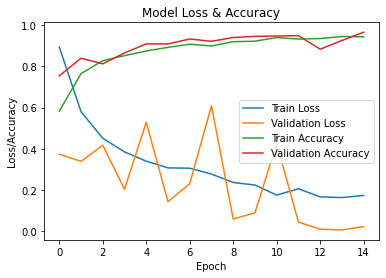

In [13]:
#Plot the loss and accuracy of model
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(model_fit.history['loss'], label='Train Loss')
plt.plot(model_fit.history['val_loss'], label='Validation Loss')
plt.plot(model_fit.history['accuracy'], label='Train Accuracy')
plt.plot(model_fit.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Loss & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

Saving 8HKeT2oFz3gPSW0p.png to 8HKeT2oFz3gPSW0p.png
This image is rock


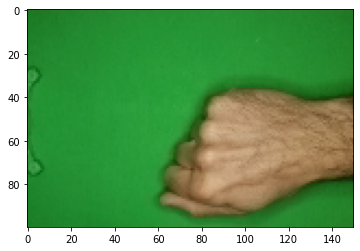

In [14]:
# Upload the image
from google.colab import files

image_file = files.upload()

for name in image_file.keys():
  img = image.load_img(name, target_size=(100, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  test_image = np.vstack([x])
  cls = model.predict(test_image, batch_size=5)
  if (cls==np.array([[1., 0., 0.]])).all()==True:
    print('This image is paper')
  elif (cls==np.array([[0., 1., 0.]])).all()==True:
    print('This image is rock')
  else:
    print('This image is scissors')